In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
from tfrecord.torch.dataset import TFRecordDataset
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import torch.nn.functional as F
import torch.nn as nn

import torch.optim as optim
from tqdm.auto import tqdm
import copy

from utils import load

from attrdict import AttrDict
import json
import deepdish as dd
import seaborn as sns

### aux functions

In [2]:
lf_meta = pd.read_csv('../data_export/landfire_metadata/LF23_F40_240.csv')
lf_meta.drop(index = 0,inplace= True)

landfire_fuel_classes = dict(zip(lf_meta['VALUE'],lf_meta['FBFM40']))

kys = list(landfire_fuel_classes.keys())
fuel_classes = {i:landfire_fuel_classes[x] for i,x in enumerate(kys)}
fuel_class_map = {x:i for i,x in enumerate(kys)}

def replace_categories(value):
    try:
        return fuel_class_map[value]
    except KeyError:
        return float('nan')

def get_pcts(arr): # takes (B,H,W) array
    B,H,W = arr.shape
    n_cats = len(kys)
    res = torch.zeros((B,n_cats))
    for i,img in enumerate(arr):
        for k,cat in enumerate(kys):
            res[i,k] = torch.sum(arr[i] == cat).item()/256
    return res

def process_batch(data_batch,onehot = True):
    data = data_batch['fbfm'].clone()
    data = data.reshape((data.shape[0],16,16))
    labels = get_pcts(data)
    data.apply_(replace_categories)
    if onehot:
        data = F.one_hot(data.long(),num_classes = len(kys)).float()
    return data,labels

### load and test model

In [13]:
# specify config manually if needed

# config = AttrDict({
#     "conv_channels":[32, 32],
#     "kernel_sizes":[3, 3,3],
#     "strides":[1, 1,1],
#     "paddings":[1, 1,1],
#     "pooling":'max',
#     "pool_kernels":[2, 2,2],
#     "encoder_hidden_dims":[32,16],
#     "latent_dim":3,
#     "decoder_hidden_dims":[8,16,32],
#     "weights_seed":123,
#     "learning_rate":1e-4
# })

In [14]:
run_name = 'fifth_model_run'

with open(f'models/{run_name}.json','r') as json_file:
    config = AttrDict(json.load(json_file))

In [10]:
model_config_file = 'fuel_autoencoder_config.py'
model,name = load(model_config_file,config)

Loading 'fuel_autoencoder_config' from /Users/gorg/Documents/ndws/fuel_embedding/fuel_autoencoder_config.py


In [11]:
weights = torch.load(f'models/{run_name}.pth',weights_only = True)

In [12]:
model.load_state_dict(weights)
model.eval().cpu()

fuel_autoencoder(
  (encoder): Encoder(
    (activation): ReLU()
    (conv_layers): ModuleList(
      (0): Conv2d(45, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (pool_layers): ModuleList(
      (0-1): 2 x MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (fc_layers): ModuleList(
      (0): Linear(in_features=512, out_features=32, bias=True)
      (1): Linear(in_features=32, out_features=16, bias=True)
      (2): Linear(in_features=16, out_features=3, bias=True)
    )
    (fc_batch_norms): ModuleList(
      (0): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (decoder): Decoder(
    (activation): ReLU()
    (fc_layers): ModuleList(
      (0): Linear(in_features=3, out_features=8, bias=True)
      (1): Linear(in_features=8,

### Load dataset and evaluate model performance

In [197]:
# Load testing dataset
modes = ['train','test','val']
data_loaders = {}
for mode in modes:
    tfrecord_path = f"dataset/conus_west_fbfm40_{mode}.tfrecord"
    index_path = None
    description = {"fbfm": "float"}
    dataset = TFRecordDataset(tfrecord_path, index_path, description)
    loader = torch.utils.data.DataLoader(dataset, batch_size=2048)
    data_loaders[mode] = loader

In [198]:
def evaluate_autoencoder(model,loader):
    model = model.eval()
    device = torch.device('mps')
    model.to(device)
    mse = []
    mae = []
    kl_divs = []
    KLD = nn.KLDivLoss(reduction='batchmean')
    for batch in tqdm(loader):
        data,labels = process_batch(batch)
        data = data.to(device)
        with torch.no_grad():
            model_output = model(data).cpu()
        model_probs = F.softmax(model_output,dim = -1)
        model_log_probs = F.log_softmax(model_output,dim = -1)
        kld = KLD(model_log_probs,labels)
        kl_divs.append(kld.item())
        mse.append(torch.sum((model_probs - labels)**2/labels.shape[0]).item())
        mae.append(torch.sum(torch.abs(model_probs - labels)/labels.shape[0]).item())
    return {'kl':kl_divs,'mse':mse,'mae':mae} 

In [ ]:
for mode in ['test','train']:
    eval = evaluate_autoencoder(model,data_loaders[mode])
    dd.io.save(f'model_evals/{run_name}_{mode}.h5',eval)

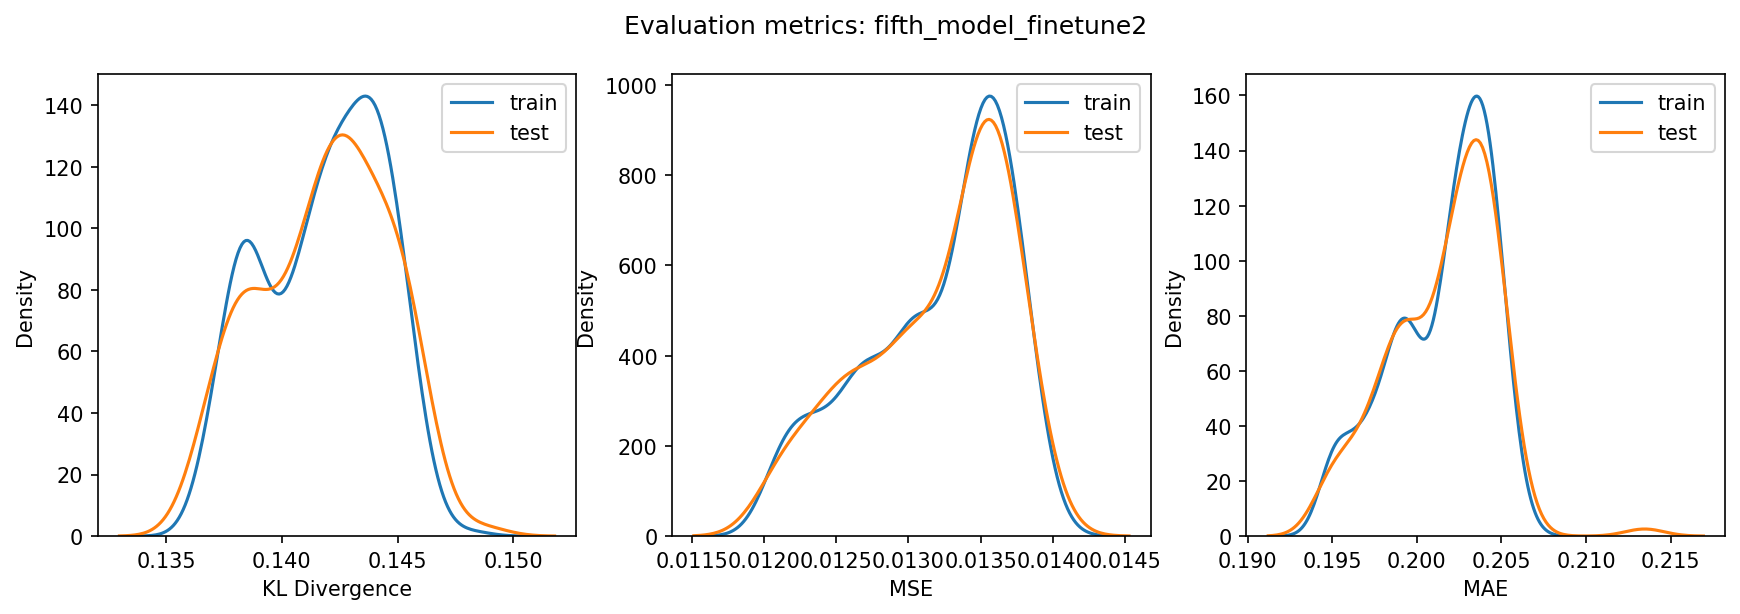

In [203]:
# run_name = 'fifth_model_finetune2'

fig,axes = plt.subplots(1,3,figsize = (14,4),dpi = 150)
modes = ['train','test']
for mode in modes:
    eval_filename = f'model_evals/{run_name}_{mode}.h5'
    evals = dd.io.load(eval_filename)

    sns.kdeplot(evals['kl'],ax = axes[0],label = mode,common_norm = True)
    axes[0].set_xlabel("KL Divergence")
    axes[0].legend()

    sns.kdeplot(evals['mse'],ax = axes[1],label = mode,common_norm = True)
    axes[1].set_xlabel("MSE")
    axes[1].legend()

    sns.kdeplot(evals['mae'],ax = axes[2],label = mode,common_norm = True)
    axes[2].set_xlabel("MAE")
    axes[2].legend()

fig.suptitle(f"Evaluation metrics: {run_name}")
plt.savefig(f"model_evals/{run_name}_metrics.pdf",bbox_inches = 'tight')
plt.show()

In [40]:
data,labels = process_batch(batch)

In [63]:
encoder = model.encoder

In [65]:
with torch.no_grad():
    latent = encoder(data)

In [43]:
with torch.no_grad():
    outputs = F.softmax(model(data),dim = -1)

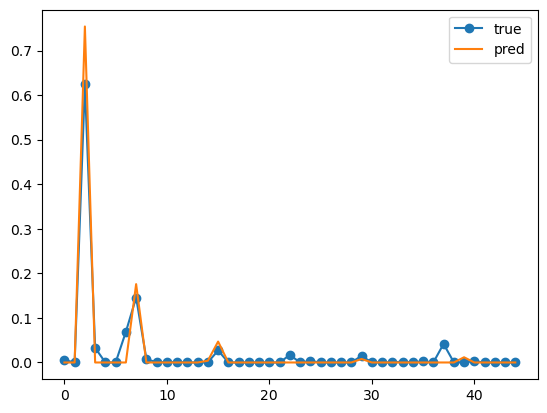

In [62]:
ind = 400
plt.plot(outputs[ind],marker = 'o',label = 'true')
plt.plot(labels[ind],label = 'pred')
plt.legend()